# 6.2 순환 신경망 이해하기
- **피드포워드 네트워크**(feedforward network)
- 완전 연결 네트워크와 컨브넷에 주입되는 입력은 개별적으로 처리되며 입력 간에 유지되는 상태가 없음 (메모리가 없음)
- 이런 네트워크에 시퀀스나 시계열 데이터를 주입하려면 전체 시퀀스를 하나의 데이터 포인트로 변환해야 함(IMDB에서 각 리뷰를 벡터 변환 하듯이)
- **순환 신경망**(Recurrent Nueral Network; RNN) : 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 **상태**(state)에 저장, 루프를 가진 신경망

### 간단한 RNN 정방향 계산
- 크기가 `(timesteps, input_features)`인 2D 텐서로 인코딩된 벡터의 시퀀스를 입력 받음
- 각 타임스텝 `t`에서 현재 상태와 입력을 연결하여 출력을 계산
- 그 다음 이 출력을 다음 스텝의 상태로 설정
- 네트워크의 **초기 상태**(initial state)는 0인 벡터로 초기화

의사코드로 표현한 RNN
```python
state_t = 0 # 타입스텝 t의 상태
for input_t in input_sequence: # 시퀀스의 원소를 반복
    output_t = f(input_t, state_t)
    state_t = output_t # 다음 반복을 위한 상태로 출력을 설정
```

좀 더 자세한 의사코드로 표현한 RNN
```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

### 넘파이로 구현한 간단한 RNN

In [1]:
import numpy as np

timesteps = 100 # 입력 시퀀스에 있는 타임스텝의 수
input_features = 32 # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원

inputs = np.random.random((timesteps, input_features)) # 입력 데이터 (난수 생성)

state_t = np.zeros((output_features,)) # 초기 상태 : 모두 0인 벡터

# 랜덤한 가중치 행렬 생성
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs: # input_t의 크기 : (input_features,)
    # 입력과 현재 상태(이전 출력)을 연결하여 현재 출력을 얻음
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    successive_outputs.append(output_t)
    
    state_t = output_t # 다음 타임스텝을 위해 네트워크의 상태를 업데이트 (은닉 상태(hidden state)라고 부름)
    
# 최종 출력은 크기가 (timesteps, output_features)인 2D 텐서
final_output_seqeunce = np.stack(successive_outputs, axis=0)

In [3]:
final_output_seqeunce.shape

(100, 64)

## 6.2.1 케라스의 순환 층
- 넘파이로 구현한 RNN이 케라스의 `SimpleRNN`
- 다른 점은 input size가 `(batch_size, timesteps, input_features)`인 것
- 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나 마지막 출력만 선택하여 반환할 수 있음

### 마지막 타임스텝의 출력만 얻는 예제

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


### 전체 상태 시퀀스를 반환하는 예제

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


- 네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 경우

In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32)) # 맨 위 층만 마지막 출력을 반환
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


### IMDB 데이터 전처리하기

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000 # 특성으로 사용할 단어의 수
maxlen = 500 # 사용할 텍스트의 길이
batch_size = 32

print('데이터 로딩 ...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기 :', input_train.shape)
print('input_test 크기 :', input_test.shape)

데이터 로딩 ...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기 : (25000, 500)
input_test 크기 : (25000, 500)


### Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기

In [8]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 101s 624ms/step - loss: 0.6413 - accuracy: 0.6206 - val_loss: 0.4983 - val_accuracy: 0.7590
Epoch 2/10
157/157 [==============================] - 98s 621ms/step - loss: 0.3414 - accuracy: 0.8575 - val_loss: 0.3432 - val_accuracy: 0.8580
Epoch 3/10
157/157 [==============================] - 97s 617ms/step - loss: 0.3109 - accuracy: 0.8772 - val_loss: 0.3619 - val_accuracy: 0.8484
Epoch 4/10
157/157 [==============================] - 98s 625ms/step - loss: 0.1594 - accuracy: 0.9453 - val_loss: 0.3719 - val_accuracy: 0.8576
Epoch 5/10
157/157 [==============================] - 98s 626ms/step - loss: 0.0895 - accuracy: 0.9735 - val_loss: 0.4216 - val_accuracy: 0.8450
Epoch 6/10
157/157 [==============================] - 94s 602ms/step - loss: 0.0462 - accuracy: 0.9890 - val_loss: 0.4382 - val_accuracy: 0.8600
Epoch 7/10
157/157 [==============================] - 93s 595ms/step - loss: 0.0587 - accuracy: 0.9812 - val_loss: 0.4989 - val_a

### 결과 그래프 그리기

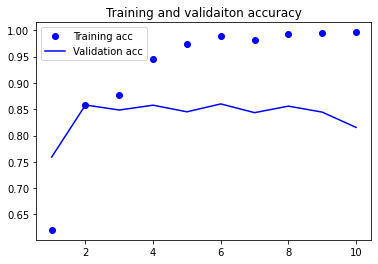

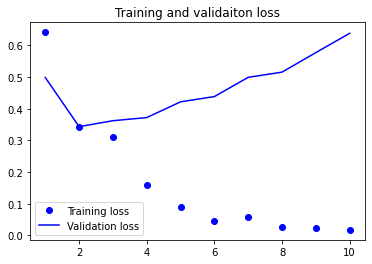

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validaiton accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validaiton loss')
plt.legend()

plt.show()

- 3장의 모델 정확도는 87~88%로 RNN을 이용했을 때보다 더 높음
    - 원인 : 전체 시퀀스가 아닌 500개의 단어만 입력에 사용했기 때문, RNN이 긴 시퀀스를 처리하는 데 적합하지 않기 때문

## 6.2.2 LSTM과 GRU 층 이해하기
- `SimpleRNN`은 실전에서 사용하기에는 너무 단순하기 때문에 `LSTM`과 `GRU`를 더 많이 사용함
    - **그래디언트 소실 문제**(vanishing gradient problem) 때문(역전파가 진행되는 동안 타임스텝마다 동일한 가중치를 사용하기 때문에 타임스텝이 길어질수록 그래디언트 값이 급격히 줄어들거나 증가하는 문제)
- `LSTM`(장단기 메모리(Long Short-Term Memory)) 알고리즘 : 1997년 호크라이터와 슈미트후버가 개발
    - 나중을 위한 정보를 저장함으로써 처리 과정에서 오래된 시그널이 소실되는 것을 막음
    - 타임스텝을 가로질러 정보를 나르는 데이터 이동 상태를 `c_t`라고 부름 (c : 이동(carry))
    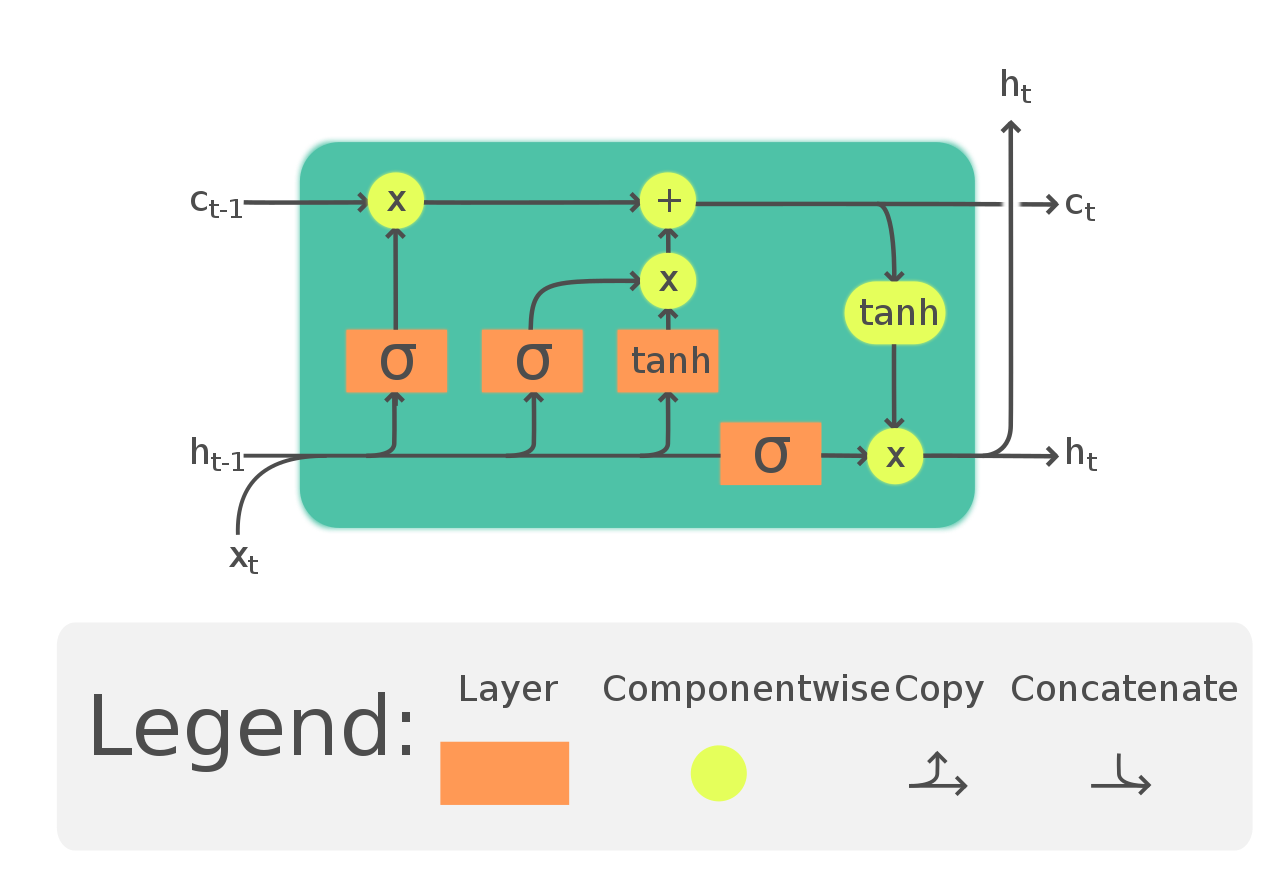
    출처 : https://en.wikipedia.org/wiki/Long_short-term_memory

LSTM 구조의 의사 코드

```python
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)

# sigmoid 활성화 함수
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)

# tanh 활성화 함수
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

(c_t+1) = i_t * k_t + c_t * f_t
```

- 삭제 게이트(forget gate) : `f_t`, 이동을 위한 데이터 흐름에서 관련이 적은 정보를 의도적으로 삭제
- 입력 게이트(input gate) : `i_t`, 현재에 대한 정보를 제공하고 이동 트랙을 새로운 정보로 업데이트
- 그러나 이런 해석은 큰 의미가 없으며 실제로 하는 일은 연산에 관련된 가중치 행렬에 따라 결정되기 때문
- LSTM 셀의 구체적인 구조에 대해 이해할 필요가 전혀 없으며 "과거 정보를 나중에 다시 주입하여 그래디언트 소실 문제를 해결한다"는 역할만 기억하면 됨

## 6.2.3 케라스를 사용한 LSTM 예제
- `LSTM` 층은 출력 차원만 지정하고 다른 매개변수는 케라스의 기본값으로 설정
    - 기본값만으로도 충분히 좋은 모델을 만들 수 있기 때문

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 10s 21ms/step - loss: 0.5020 - accuracy: 0.7512 - val_loss: 0.3569 - val_accuracy: 0.8518
Epoch 2/10
157/157 [==============================] - 3s 19ms/step - loss: 0.2675 - accuracy: 0.8975 - val_loss: 0.2920 - val_accuracy: 0.8792
Epoch 3/10
157/157 [==============================] - 3s 19ms/step - loss: 0.1875 - accuracy: 0.9331 - val_loss: 0.3058 - val_accuracy: 0.8822
Epoch 4/10
157/157 [==============================] - 3s 19ms/step - loss: 0.1366 - accuracy: 0.9531 - val_loss: 0.3545 - val_accuracy: 0.8734
Epoch 5/10
157/157 [==============================] - 3s 19ms/step - loss: 0.1059 - accuracy: 0.9642 - val_loss: 0.3662 - val_accuracy: 0.8764
Epoch 6/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0840 - accuracy: 0.9740 - val_loss: 0.3960 - val_accuracy: 0.8672
Epoch 7/10
157/157 [==============================] - 3s 19ms/step - loss: 0.0778 - accuracy: 0.9765 - val_loss: 0.4365 - val_accuracy: 0.874

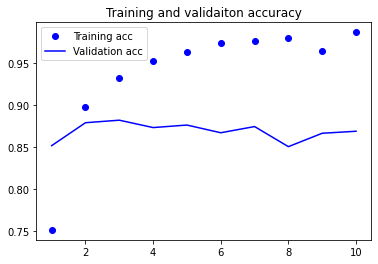

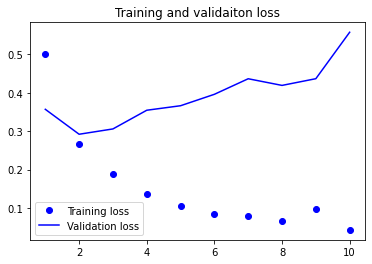

In [3]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validaiton accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validaiton loss')
plt.legend()

plt.show()

- LSTM이 그래디언트 소실 문제로부터 영향을 덜 받기 때문에 RNN보다 더 좋은 결과를 보임
- 그렇지만 획기적으로 결과가 좋은 것은 아님
    - 임베딩 차원이나 LSTM 출력 차원 같은 하이퍼파라미터 튜닝을 하지 않았기 때문
    - 규제가 없기 때문
    - 리뷰를 전체적으로 길게 분석하는 것(LSTM이 잘하는 것)은 감성 분류 문제에 도움이 되지 않기 때문
        - 오히려 완전 연결 네트워크처럼 각 리뷰에 어떤 단어가 나타나고 얼마나 등장하는지를 보는 것이 나음
- 질문-응답(question-answering)과 기계 번역(machine translation) 분야에서는 LSTM이 좋은 결과를 나타냄